Załadujmy zatem dane chodu i zobaczmy jak wyglądają szeregi czasowe które otrzymaliśmy

<Figure size 576x396 with 0 Axes>

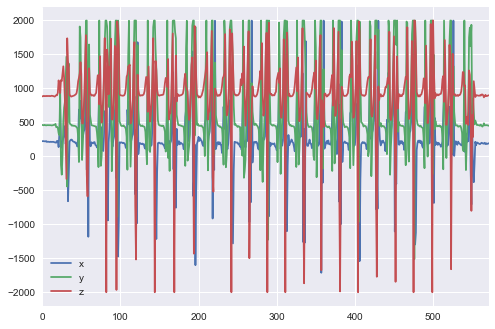

<Figure size 576x396 with 0 Axes>

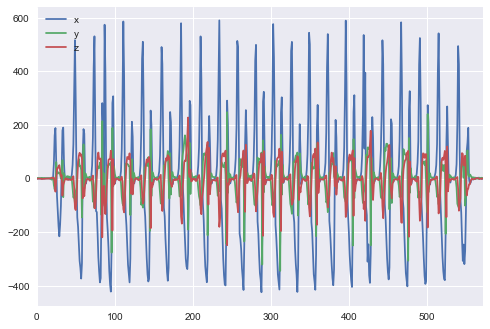

In [1]:
import pandas as pd #pakiet do pracy z szeregami czasowymi
import matplotlib.pyplot as plt #pakiet do wiualizacji
import seaborn as sns #kolejny pakiet do wizualizacji


acc = pd.read_csv('./data/accelerometry/Accelerometer.csv', skiprows=3)
gyro = pd.read_csv('./data/accelerometry/Gyroscope.csv', skiprows=3)

acc = acc[ ['X (mg)', 'Y (mg)', 'Z (mg)'] ]
gyro = gyro[ ['X (dps)', 'Y (dps)', 'Z (dps)'] ]

acc.columns = ['x', 'y', 'z'] #skrocmy nazwy kolumn
gyro.columns = ['x', 'y', 'z']

plt.figure() 
acc.plot()

plt.figure()
gyro.plot()

plt.show()

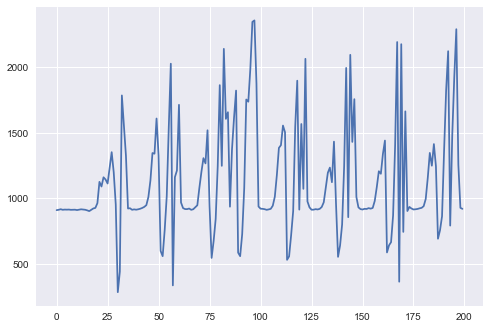

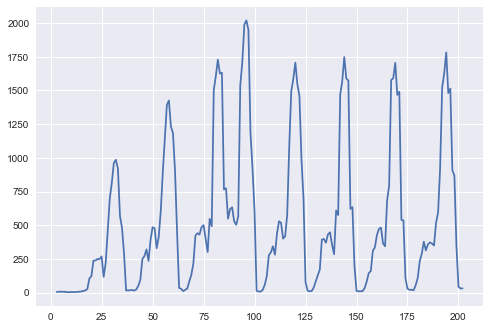

In [2]:
#zróbmy detekcje kroku
import numpy as np #pakiet do pracy z wektorami i macierzami


e = np.sqrt(acc['x']**2 + acc['y']*2 + acc['z']**2)
# e = np.sqrt(gyro['x']**2 + gyro['y']*2 + gyro['z']**2)

plt.plot(e[:200])
plt.show()

#obliczmy wariancję przy użyciu 'rolling window'
acc_std = acc.rolling(window = 5, center = True).std()
acc_std = acc_std[3:-3]

e = np.sqrt(acc_std['x']**2 + acc_std['y']*2 + acc_std['z']**2)
plt.plot(e[:200])
plt.show()
    


Wykryjmy teraz fazy 'zerowej predkosci' w ruchu stopy. Zastosujemy w tym przypadku progrowanie 
ustalimy prog 'thres' i oznaczymy fragmenty szeregu.

Pozostaje pytanie jak znaleźć ten próg? moglibyśmy go najzwyczajniej w świecie wyczytać z wykresu powyżej... ale to byłoby zbyt proste.



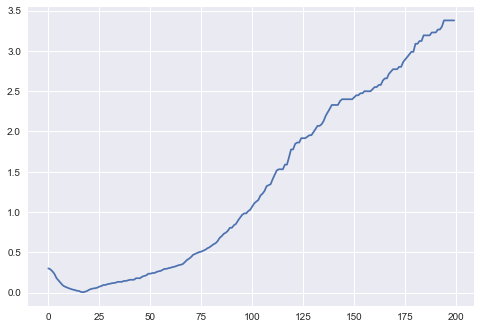

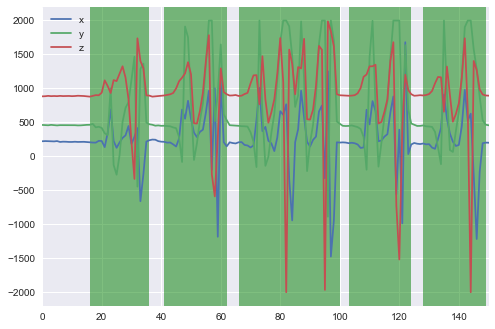

In [3]:
proportions = np.zeros(200) #pusty wektor na wyniki
search_space = np.linspace(0, 0.5*e.max(), 200) #przestrzeń poszukiwania

for i, thres_i in enumerate(search_space):
    prop = float(np.sum(e<thres_i) ) / np.sum(e>=thres_i)
    prop = np.abs(0.3 - prop) #nasze założenie
    proportions[i] = prop
    

plt.plot(proportions)
plt.show()

threshold = search_space[proportions.argmin()]

zupt_indx = np.zeros(len(e))
zupt_indx[e > threshold] = 1.0
zupt_indx = zupt_indx[1:] - zupt_indx[:-1]

starts = np.argwhere(zupt_indx == 1).flatten() + 1
ends = np.argwhere(zupt_indx == -1).flatten() + 1

ax = acc.plot()
for (s_i, e_i) in zip(starts, ends):
    ax.axvspan(s_i, e_i+2, facecolor='g', alpha=0.5)
    
plt.xlim(0,150)
plt.show()

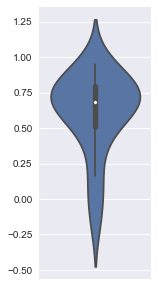

In [24]:
step_lengths = []

y0 = acc['y'][0]

for s_i, e_i in zip(starts, ends):    
    step_y = acc['y'][s_i : e_i] - y0
    length = np.sum(np.cumsum(step_y * (9.8/1000)*0.05) * 0.05)
    step_lengths.append(length)
    
#outlier removal
step_lengths_std = np.std(step_lengths)
step_lengths_mean = np.mean(step_lengths)
step_lengths = [sl for sl in step_lengths if np.abs(step_lengths_mean - sl) < 2*step_lengths_std]
    
plt.figure(figsize=(2,5))
sns.violinplot(step_lengths, orient='v')
plt.show()


#std jest bardzo często określana jako miara 'zmienności chodu'

Niemniej jednak powinniśmy całkować w układzie nawigacyjnym (czyli takim po którym porusza się człowiek) a dokonaliśmy całkowania w układzie sensora. 

Założmy jednak, że zrobiliśmy to "porządnie" otrzymamy wtedy kroki w układzie nawigacyjnym

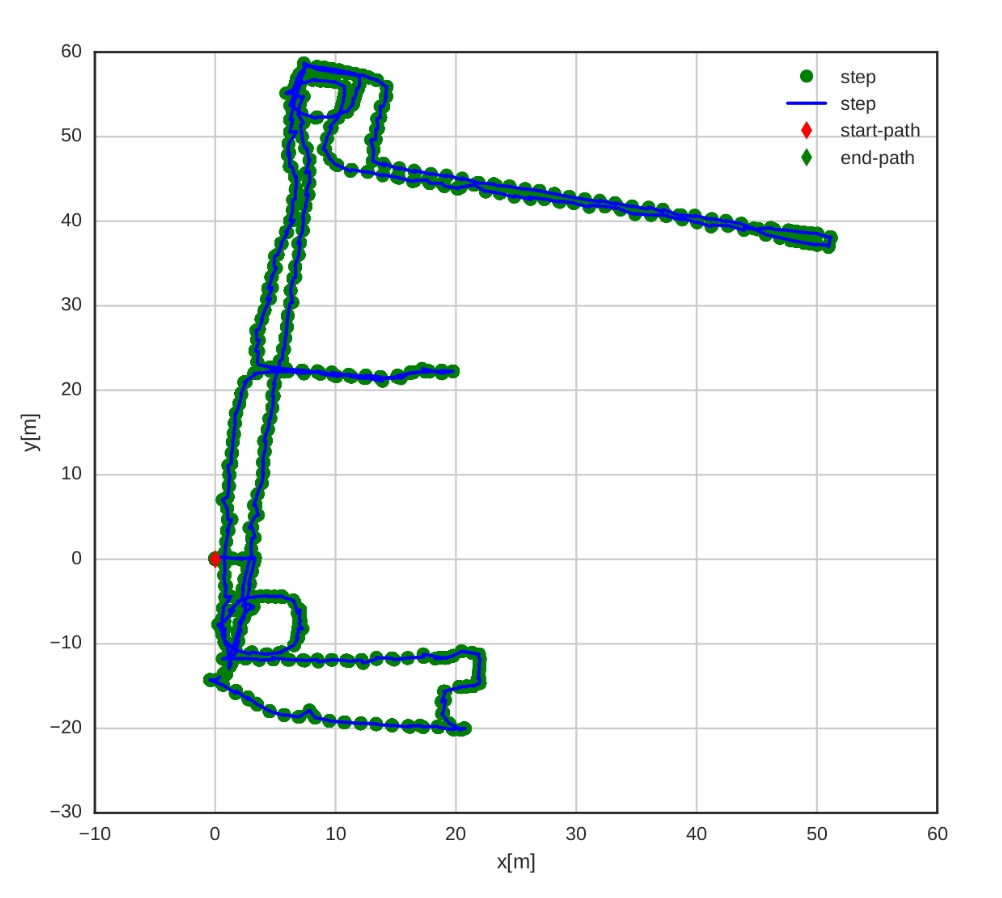

Przyjrzyjmy się jednak poszczególnym krokom i zróbmy "inżynierię cech"

In [5]:
df = pd.read_csv('./data/accelerometry/steps.csv')
df

,Unnamed: 0,code,dataset,serie,leg,e_x,e_y
0,0,S31MMSY,young,1s,left,0.628022,0.356636
1,1,S31MMSY,young,1s,left,-0.275873,0.371173
2,2,S31MMSY,young,1s,left,0.008007,0.863887
3,3,S31MMSY,young,1s,left,0.202019,0.292600
4,4,S31MMSY,young,1s,left,0.232008,0.639316
5,5,S31MMSY,young,1s,left,0.256488,1.178443
6,6,S31MMSY,young,1s,left,0.015234,1.467699
7,7,S31MMSY,young,1s,left,-0.225430,1.258742
8,8,S31MMSY,young,1s,left,-0.099477,1.408675
9,9,S31MMSY,young,1s,left,-0.055174,1.391737


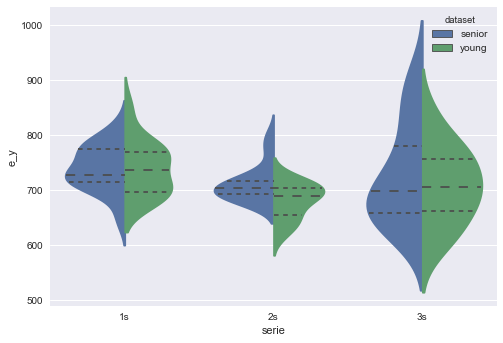

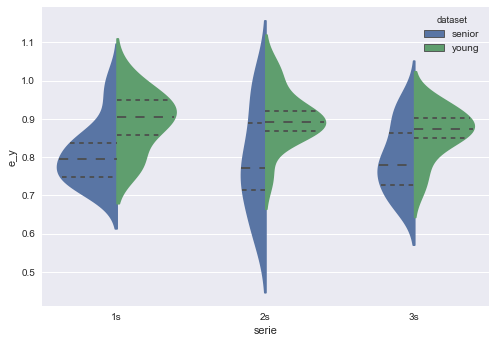

F_onewayResult(statistic=6.91735483353282, pvalue=0.013925028098887583)
F_onewayResult(statistic=7.424666306867948, pvalue=0.011148968396083935)


In [6]:
path_length = df.groupby(['dataset', 'code', 'serie']).sum()
step_mean = df.groupby(['dataset', 'code', 'serie']).mean()

#splaszczymy teraz grupowanie
path_length = path_length.reset_index()
step_mean = step_mean.reset_index()

plt.figure(); 
sns.violinplot(data=path_length, x ='serie', y='e_y', hue='dataset', split=True, inner="quartile")

plt.figure(); 
sns.violinplot(data=step_mean, x ='serie', y='e_y', hue='dataset', split=True, inner="quartile")



plt.show()

import scipy.stats as stats

path_length = path_length[path_length['serie'] == '2s']
length_2s_senior = path_length[path_length['dataset'] == 'senior']['e_y']
length_2s_young = path_length[path_length['dataset'] == 'young' ]['e_y']

step_mean = step_mean[step_mean['serie'] == '2s']
step_mean_2s_senior = step_mean[step_mean['dataset'] == 'senior']['e_y']
step_mean_2s_young = step_mean[step_mean['dataset'] == 'young' ]['e_y']

print stats.f_oneway(length_2s_senior, length_2s_young)

#tego nie powinniśmy robić gdyż odchylenia std są bardzo różne
print stats.f_oneway(step_mean_2s_senior, step_mean_2s_young)

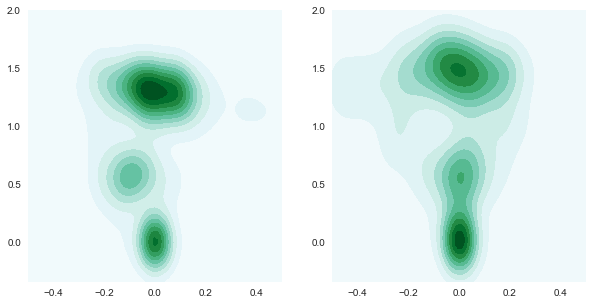

In [7]:
#Zgeneralizujemy teraz pojęcie 'zmienności chodu'

grouped =  df.groupby(['dataset', 'code', 'serie', 'leg'])

grouped = dict(list(grouped))

# print grouped.keys()
 
y_k = ('young', 'T9YD7DY', '2s', 'right')
s_k = ('senior', 'U51CZUG', '2s', 'right')


grouped[s_k][['e_x', 'e_y']].describe()

fig = plt.figure(figsize = (10,5))
ax_left = fig.add_subplot(121)
ax_right = fig.add_subplot(122, sharex=ax_left, sharey=ax_left)

sns.kdeplot(grouped[y_k][['e_x', 'e_y']], ax =ax_left, gridsize = 200, cut=5, shade=True)
sns.kdeplot(grouped[s_k][['e_x', 'e_y']], ax =ax_right, gridsize = 200, cut=5, shade=True)
ax_right.set_ylim((-0.35, 2.0))
ax_right.set_xlim((-0.5, 0.5))
plt.show()

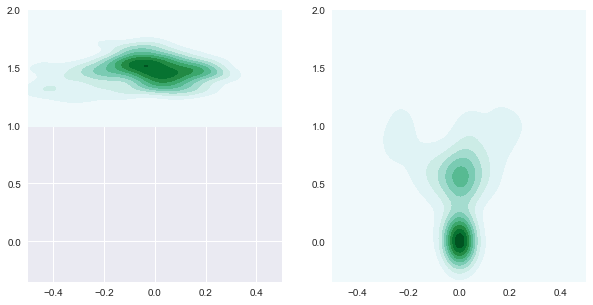

In [8]:
from sklearn import mixture

obs = grouped[s_k][['e_x', 'e_y']]
g = mixture.GaussianMixture(n_components=2)
g.fit(obs)
predicted = g.predict(obs)

fig = plt.figure(figsize = (10,5))
ax_left = fig.add_subplot(121)
ax_right = fig.add_subplot(122, sharex=ax_left, sharey=ax_left)

clip = [(-0.5, 0.5), (-0.35, 2.0)]


sns.kdeplot(obs[predicted == 0], ax =ax_left, gridsize = 200, cut=5, shade=True)
sns.kdeplot(obs[predicted == 1], ax =ax_right, gridsize = 200, cut=5, shade=True)

ax_right.set_ylim((-0.35, 2.0))
ax_right.set_xlim((-0.5, 0.5))
plt.show()

In [9]:
#ale założmy już ze mamy zrobioną inzynierie cech 

df_features = pd.read_csv('./data/accelerometry/steps_merged.csv')

features = ['LP_step_count', 'MP_step_count', 'DP_step_count', 'length_LP_mean', 'length_LP_std', 'length_MP_mean', 'length_MP_std', 'length_DP_mean', 'length_DP_std',  'length_kl_LP-MP', 'length_kl_LP-DP', 'length_kl_MP-DP',  'length_kl_left_LP-MP', 'length_kl_left_MP-DP', 'length_kl_left_MP-DP', 'length_kl_right_LP-MP', 'length_kl_right_LP-DP', 'length_kl_right_MP-DP', 'length_mean_LP-MP', 'length_mean_LP-DP', 'path_len_LP_left', 'path_len_LP_right', 'path_len_MP_left', 'path_len_MP_right', 'path_len_DP_left', 'path_len_DP_right', 'LP_length_CONT_mean', 'LP_length_CONT_proportion', 'LP_length_CONT_std', 'LP_time_CONT_mean', 'LP_time_CONT_std', 'MP_length_CONT_mean', 'MP_length_CONT_std', 'MP_time_CONT_mean', 'MP_time_CONT_std', 'DP_length_CONT_mean', 'DP_length_CONT_std', 'DP_time_CONT_mean', 'DP_time_CONT_std', 'time_LP_mean', 'time_LP_std', 'time_MP_mean', 'time_MP_std', 'time_DP_mean', 'time_DP_std',  'time_kl_LP-MP',  'time_kl_LP-DP', 'time_kl_MP-DP',  'time_kl_left_LP-MP', 'time_kl_left_LP-DP', 'time_kl_left_MP-DP', 'time_kl_right_LP-MP', 'time_kl_right_LP-DP', 'time_kl_right_MP-DP', 'emd_LP_MP-left', 'emd_LP_DP-left', 'emd_MP_DP-left', 'emd_LP_MP-right', 'emd_LP_DP-right', 'emd_MP_DP-right']

feature2group_d = {'LP_step_count' : 0 ,'MP_step_count' : 0 ,'DP_step_count' : 0 ,'length_LP_mean' : 3 ,'length_LP_std' : 1 ,'length_MP_mean' : 3 ,'length_MP_std' : 1 ,'length_DP_mean' : 3 ,'length_DP_std' : 1 ,'length_kl_LP-MP' : 2 ,'length_kl_LP-DP' : 2 ,'length_kl_MP-DP' : 2 ,'length_kl_left_LP-MP' : 2 ,'length_kl_left_MP-DP' : 2 ,'length_kl_left_MP-DP' : 2 ,'length_kl_right_LP-MP' : 2 ,'length_kl_right_LP-DP' : 2 ,'length_kl_right_MP-DP' : 2 ,'length_mean_LP-MP' : 2 ,'length_mean_LP-DP' : 2 ,'path_len_LP_left' : 0 ,'path_len_LP_right' : 0 ,'path_len_MP_left' : 0 ,'path_len_MP_right' : 0 ,'path_len_DP_left' : 0 ,'path_len_DP_right' : 0 ,'LP_length_CONT_mean' : 3 ,'LP_length_CONT_proportion' : 1 ,'LP_length_CONT_std' : 1 ,'LP_time_CONT_mean' : 3 ,'LP_time_CONT_std' : 1 ,'MP_length_CONT_mean' : 3 ,'MP_length_CONT_std' : 1 ,'MP_time_CONT_mean' : 3 ,'MP_time_CONT_std' : 1 ,'DP_length_CONT_mean' : 3 ,'DP_length_CONT_std' : 1 ,'DP_time_CONT_mean' : 3 ,'DP_time_CONT_std' : 1 ,'time_LP_mean' : 3 ,'time_LP_std' : 1 ,'time_MP_mean' : 3 ,'time_MP_std' : 1 ,'time_DP_mean' : 3 ,'time_DP_std' : 1 ,'time_kl_LP-MP' : 2 ,'time_kl_LP-DP' : 2 ,'time_kl_MP-DP' : 2 ,'time_kl_left_LP-MP' : 2 ,'time_kl_left_LP-DP' : 2 ,'time_kl_left_MP-DP' : 2 ,'time_kl_right_LP-MP' : 2 ,'time_kl_right_LP-DP' : 2 ,'time_kl_right_MP-DP' : 2 ,'emd_LP_MP-left' : 2 ,'emd_LP_DP-left' : 2 ,'emd_MP_DP-left' : 2 ,'emd_LP_MP-right' : 2 ,'emd_LP_DP-right' : 2 ,'emd_MP_DP-right' : 2}

# feature2group = [0, 0, 0, 3, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
feature2group = np.array( map(feature2group_d.get, features) )
featuregroup2name = ['task', 'gait variability', 'gait changes' , 'physiological']

print len(features)
df_features

60


,Unnamed: 0,Unnamed:,LP_step_count,MP_step_count,DP_step_count,code,dataset,length_LP_mean,length_LP_std,length_LP_var,...,step_count_LP-DP,path_len_LP-MP.1,path_len_MP-DP,path_len_LP-DP.1,emd_LP_MP-left,emd_LP_DP-left,emd_MP_DP-left,emd_LP_MP-right,emd_LP_DP-right,emd_MP_DP-right
0,0,0,766,733,789,S31MMSY,young,1.046772,0.495534,0.473392,...,23,61.548118,-45.701430,-15.846687,1.764853,2.099481,2.197509,2.129563,2.231989,2.566100
1,1,1,985,1176,959,GUNPCNY,senior,0.754686,0.423905,0.561697,...,-26,1.129068,21.185406,-22.314474,1.546890,1.883230,1.327442,4.479638,2.745420,3.446136
2,2,2,771,791,1035,JC98CY8,senior,1.026245,0.382506,0.372724,...,264,-3.200689,-77.084548,80.285237,2.101968,3.365422,2.480223,2.256198,4.426970,2.599619
3,3,4,731,654,709,ZIMNA,young,0.957116,0.536319,0.560349,...,-22,4.723992,21.615391,-26.339383,2.088297,3.432076,2.689079,1.576144,2.536332,2.776488
4,4,5,920,748,820,PC2EUMI,young,0.949498,0.470905,0.495951,...,-100,78.854430,17.149082,-96.003512,1.805384,3.122364,3.832065,1.384117,2.566904,2.878520
5,5,6,786,803,835,APMG,young,0.910761,0.433330,0.475789,...,49,1.004086,-10.500445,9.496359,2.009973,3.203475,2.085193,1.702152,2.913587,1.951375
6,6,7,916,895,856,40UTW,senior,0.728617,0.318552,0.437202,...,-60,-16.244485,14.234254,2.010231,2.232391,3.297468,1.833142,2.879595,3.520138,1.710736
7,7,8,984,999,899,3Q6D52M,senior,0.768551,0.397209,0.516829,...,-85,6.848517,43.267541,-50.116058,1.356132,2.026309,1.621100,1.326636,2.399982,2.200513
8,8,9,699,767,827,MCZK,young,1.000156,0.425514,0.425448,...,128,-6.561716,-36.482083,43.043800,2.233498,1.689768,2.031211,1.957793,1.591573,1.804701
9,9,10,804,738,758,4SS94HU,young,0.989965,0.498731,0.503787,...,-46,50.978029,-20.754944,-30.223086,1.183581,1.382280,1.658409,1.803312,2.294873,2.237432


In [10]:
XX = df_features[features].values 

from sklearn import decomposition

pca_0 = decomposition.KernelPCA(n_components=1, kernel = 'linear')
pca_1 = decomposition.KernelPCA(n_components=1, kernel = 'linear')
pca_2 = decomposition.KernelPCA(n_components=1, kernel = 'linear')
pca_3 = decomposition.KernelPCA(n_components=1, kernel = 'linear')

p0 = pca_0.fit_transform( XX[:,feature2group == 0])
p1 = pca_1.fit_transform( XX[:,feature2group == 1])
p2 = pca_2.fit_transform( XX[:,feature2group == 2])
p3 = pca_3.fit_transform( XX[:,feature2group == 3])


X = np.hstack([p0, p1, p2, p3])

y = df_features['dataset'].values
y = np.array([0 if d=='young' else 1 for d in y])

print X.shape, y.shape

from sklearn import svm, metrics, model_selection

clf = svm.LinearSVC(dual=False, C=1.0)

clf.fit(X, y)
y_pred = clf.predict(X)


print metrics.classification_report(y, y_pred)

precision_scorer = metrics.make_scorer(metrics.precision_score)

print model_selection.cross_val_score(clf, X, y=y, cv=5, scoring=precision_scorer)



(26, 4) (26,)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      1.00      1.00        13

avg / total       1.00      1.00      1.00        26

[1.         1.         0.66666667 1.         1.        ]


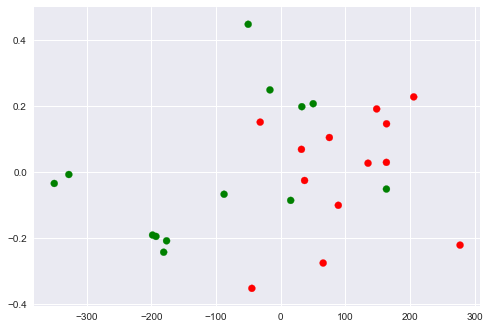

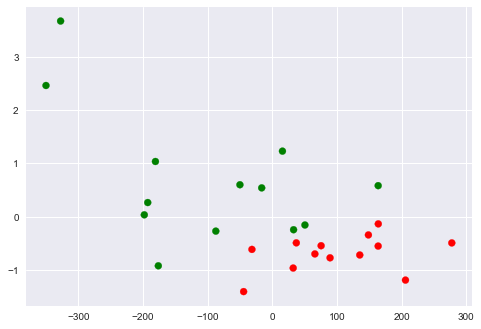

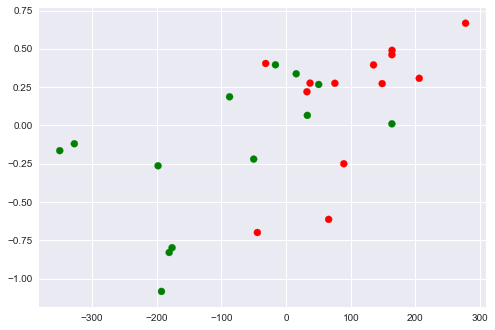

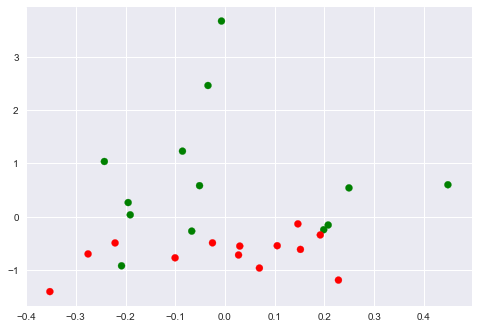

In [11]:
colors = ['r' if c==0 else 'g' for c in y]

MM = X[:,[0,1]]; plt.scatter(MM[:,0], MM[:,1], c = colors); plt.show()
MM = X[:,[0,2]]; plt.scatter(MM[:,0], MM[:,1], c = colors); plt.show()
MM = X[:,[0,3]]; plt.scatter(MM[:,0], MM[:,1], c = colors); plt.show()
MM = X[:,[1,2]]; plt.scatter(MM[:,0], MM[:,1], c = colors); plt.show()

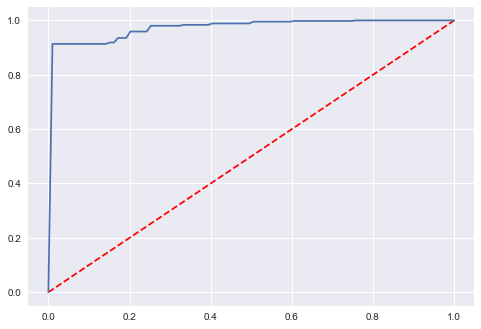

In [18]:
import sklearn
from scipy import interp

N_FOLDS = 100


X_s = X[:,[0,2]].copy()
mean_fpr = np.linspace(0, 1, 100)
tprs = []

rkf = sklearn.model_selection.RepeatedKFold(n_splits=3, n_repeats = int(N_FOLDS/3))

clf = svm.LinearSVC(dual=False, C=1.0)

for train_index, test_index in rkf.split(X_s, y):

    X_train, X_test, y_train, y_test = X_s[train_index], X_s[test_index], y[train_index], y[test_index]

    clf_f = clf.fit(X_train, y_train)

    Y_scores = clf_f.decision_function(X_test)
    Y_predicted = clf_f.predict(X_test)

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, Y_scores, drop_intermediate=False)
    
    if np.isnan(tpr).any(): continue
    if np.isnan(fpr).any(): continue
        
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)

plt.plot([0,1], [0,1], 'r--')
plt.plot(mean_fpr, mean_tpr)
plt.show()

# mean_auc_results.append((mean_auc, mean_tpr, mean_fpr))

# print mean_auc_results